# Poisson regression and non-normal loss

This example is modified from
https://scikit-learn.org/stable/auto_examples/linear_model/plot_poisson_regression_non_normal_loss.html

The original file also contains a non-linear model, namely Gradient Boosting Regression Trees.

Another example of using Poisson regression is in 
https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html#sphx-glr-auto-examples-linear-model-plot-tweedie-regression-insurance-claims-py

Scikit-Learn user guide: 
https://scikit-learn.org/stable/modules/linear_model.html#generalized-linear-models 

In [1]:
%matplotlib inline

This example illustrates the use of log-linear Poisson regression on the
[French Motor Third-Party Liability Claims dataset](https://www.openml.org/d/41214) from [1]_ and compares it with a linear
model fitted with the usual least squared error and a non-linear GBRT model
fitted with the Poisson loss (and a log-link).

A few definitions:

- A **policy** is a contract between an insurance company and an individual:
  the **policyholder**, that is, the vehicle driver in this case.

- A **claim** is the request made by a policyholder to the insurer to
  compensate for a loss covered by the insurance.

- The **exposure** is the duration of the insurance coverage of a given policy,
  in years.

- The claim **frequency** is the number of claims divided by the exposure,
  typically measured in number of claims per year.

In this dataset, each sample corresponds to an insurance policy. Available
features include driver age, vehicle age, vehicle power, etc.

Our goal is to predict the expected frequency of claims following car accidents
for a new policyholder given the historical data over a population of
policyholders.

.. [1]  A. Noll, R. Salzmann and M.V. Wuthrich, Case Study: French Motor
    Third-Party Liability Claims (November 8, 2018). [doi:10.2139/ssrn.3164764](http://dx.doi.org/10.2139/ssrn.3164764)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## The French Motor Third-Party Liability Claims dataset

Let's load the motor claim dataset from OpenML:
https://www.openml.org/d/41214



In [3]:
from sklearn.datasets import fetch_openml

In [4]:
df = fetch_openml(data_id=41214, as_frame=True, parser='auto').frame
df

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10000,D,5,0,55,50,B12,'Regular',1217,R82
1,3.0,1,0.77000,D,5,0,55,50,B12,'Regular',1217,R82
2,5.0,1,0.75000,B,6,2,52,50,B12,'Diesel',54,R22
3,10.0,1,0.09000,B,7,0,46,50,B12,'Diesel',76,R72
4,11.0,1,0.84000,B,7,0,46,50,B12,'Diesel',76,R72
...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326.0,0,0.00274,E,4,0,54,50,B12,'Regular',3317,R93
678009,6114327.0,0,0.00274,E,4,0,41,95,B12,'Regular',9850,R11
678010,6114328.0,0,0.00274,D,6,2,45,50,B12,'Diesel',1323,R82
678011,6114329.0,0,0.00274,B,4,0,60,50,B12,'Regular',95,R26


The number of claims (``ClaimNb``) is a positive integer that can be modeled
as a Poisson distribution. It is then assumed to be the number of discrete
events occurring with a constant rate in a given time interval (``Exposure``,
in units of years).

Here we want to model the frequency ``y = ClaimNb / Exposure`` conditionally
on ``X`` via a (scaled) Poisson distribution, and use ``Exposure`` as
``sample_weight``.



Average Frequency = 0.10070308464041304
Fraction of exposure with zero claims = 93.9%


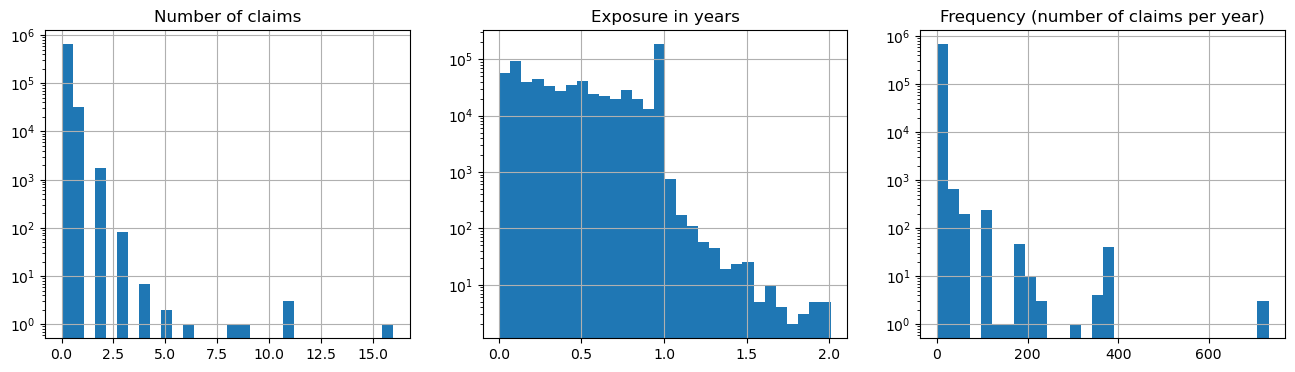

In [5]:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]

print(
    "Average Frequency = {}".format(np.average(df["Frequency"], weights=df["Exposure"]))
)

print(
    "Fraction of exposure with zero claims = {0:.1%}".format(
        df.loc[df["ClaimNb"] == 0, "Exposure"].sum() / df["Exposure"].sum()
    )
)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 4))
ax0.set_title("Number of claims")
_ = df["ClaimNb"].hist(bins=30, log=True, ax=ax0)
ax1.set_title("Exposure in years")
_ = df["Exposure"].hist(bins=30, log=True, ax=ax1)
ax2.set_title("Frequency (number of claims per year)")
_ = df["Frequency"].hist(bins=30, log=True, ax=ax2)

The remaining columns can be used to predict the frequency of claim events.
Those columns are very heterogeneous with a mix of categorical and numeric
variables with different scales, possibly very unevenly distributed.

In order to fit linear models with those predictors it is therefore
necessary to perform standard feature transformations as follows:



In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer


log_scale_transformer = make_pipeline(
    FunctionTransformer(np.log, validate=False), StandardScaler()
)

linear_model_preprocessor = ColumnTransformer(
    [
        ("passthrough_numeric", "passthrough", ["BonusMalus"]),
        (
            "binned_numeric",
            KBinsDiscretizer(n_bins=10, subsample=int(2e5), random_state=0),
            ["VehAge", "DrivAge"],
        ),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
        (
            "onehot_categorical",
            OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
    ],
    remainder="drop",
)

## A constant prediction baseline

It is worth noting that more than 93% of policyholders have zero claims. If
we were to convert this problem into a binary classification task, it would
be significantly imbalanced, and even a simplistic model that would only
predict mean can achieve an accuracy of 93%.

To evaluate the pertinence of the used metrics, we will consider as a
baseline a "dummy" estimator that constantly predicts the mean frequency of
the training sample.



In [7]:
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.33, random_state=0)

dummy = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", DummyRegressor(strategy="mean")),
    ]
).fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"])

Let's compute the performance of this constant prediction baseline with 3
different regression metrics:



In [8]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_poisson_deviance


def score_estimator(estimator, df_test):
    """Score an estimator on the test set."""
    y_pred = estimator.predict(df_test)

    print(
        "MSE: %.3f"
        % mean_squared_error(
            df_test["Frequency"], y_pred, sample_weight=df_test["Exposure"]
        )
    )
    print(
        "MAE: %.3f"
        % mean_absolute_error(
            df_test["Frequency"], y_pred, sample_weight=df_test["Exposure"]
        )
    )

    # Ignore non-positive predictions, as they are invalid for
    # the Poisson deviance.
    mask = y_pred > 0
    if (~mask).any():
        n_masked, n_samples = (~mask).sum(), mask.shape[0]
        print(
            "WARNING: Estimator yields invalid, non-positive predictions "
            f" for {n_masked} samples out of {n_samples}. These predictions "
            "are ignored when computing the Poisson deviance."
        )

    print(
        "mean Poisson deviance: %.3f"
        % mean_poisson_deviance(
            df_test["Frequency"][mask],
            y_pred[mask],
            sample_weight=df_test["Exposure"][mask],
        )
    )


print("Constant mean frequency evaluation:")
score_estimator(dummy, df_test)

Constant mean frequency evaluation:
MSE: 0.564
MAE: 0.189
mean Poisson deviance: 0.625


## (Generalized) linear models

We start by modeling the target variable with the (l2 penalized) least
squares linear regression model, more comonly known as Ridge regression. We
use a low penalization `alpha`, as we expect such a linear model to under-fit
on such a large dataset.



In [27]:
from sklearn.linear_model import Ridge


ridge_glm = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", Ridge(alpha=1e-6)),
    ]
).fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"])

The Poisson deviance cannot be computed on non-positive values predicted by
the model. For models that do return a few non-positive predictions (e.g.
:class:`~sklearn.linear_model.Ridge`) we ignore the corresponding samples,
meaning that the obtained Poisson deviance is approximate. An alternative
approach could be to use :class:`~sklearn.compose.TransformedTargetRegressor`
meta-estimator to map ``y_pred`` to a strictly positive domain.



In [28]:
print("Ridge evaluation:")
score_estimator(ridge_glm, df_test)

Ridge evaluation:
MSE: 0.560
MAE: 0.186
mean Poisson deviance: 0.597


Next we fit the Poisson regressor on the target variable. We set the
regularization strength ``alpha`` to approximately 1e-6 over number of
samples (i.e. `1e-12`) in order to mimic the Ridge regressor whose L2 penalty
term scales differently with the number of samples.

Since the Poisson regressor internally models the log of the expected target
value instead of the expected value directly (log vs identity link function),
the relationship between X and y is not exactly linear anymore. Therefore the
Poisson regressor is called a Generalized Linear Model (GLM) rather than a
vanilla linear model as is the case for Ridge regression.



In [29]:
from sklearn.linear_model import PoissonRegressor

n_samples = df_train.shape[0]

poisson_glm = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", PoissonRegressor(alpha=1e-12, solver="newton-cholesky")),
    ]
)
poisson_glm.fit(
    df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"]
)

print("PoissonRegressor evaluation:")
score_estimator(poisson_glm, df_test)

PoissonRegressor evaluation:
MSE: 0.560
MAE: 0.186
mean Poisson deviance: 0.594


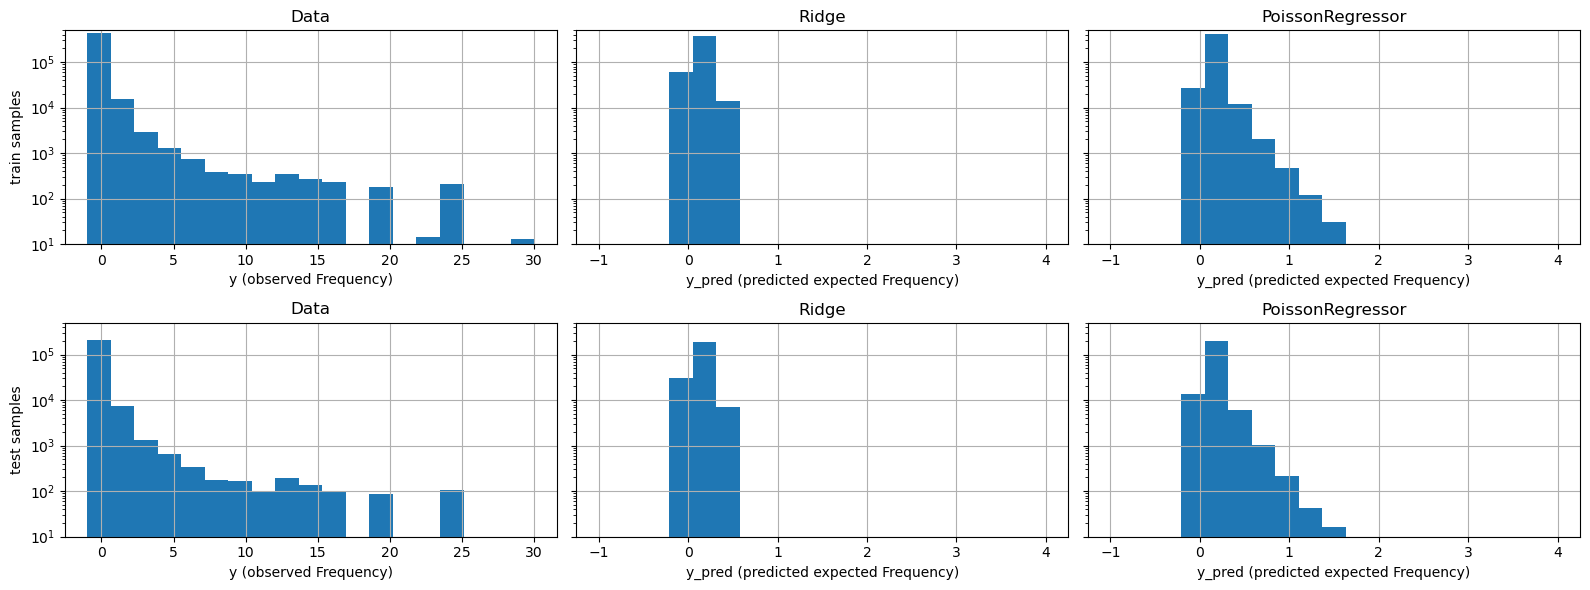

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 6), sharey=True)
fig.subplots_adjust(bottom=0.2)
n_bins = 20
for row_idx, label, df in zip(range(2), ["train", "test"], [df_train, df_test]):
    df["Frequency"].hist(bins=np.linspace(-1, 30, n_bins), ax=axes[row_idx, 0])

    axes[row_idx, 0].set_title("Data")
    axes[row_idx, 0].set_yscale("log")
    axes[row_idx, 0].set_xlabel("y (observed Frequency)")
    axes[row_idx, 0].set_ylim([1e1, 5e5])
    axes[row_idx, 0].set_ylabel(label + " samples")

    for idx, model in enumerate([ridge_glm, poisson_glm]):
        y_pred = model.predict(df)

        pd.Series(y_pred).hist(
            bins=np.linspace(-1, 4, n_bins), ax=axes[row_idx, idx + 1]
        )
        axes[row_idx, idx + 1].set(
            title=model[-1].__class__.__name__,
            yscale="log",
            xlabel="y_pred (predicted expected Frequency)",
        )
plt.tight_layout()

The experimental data presents a long tail distribution for ``y``. In all
models, we predict the expected frequency of a random variable, so we will
have necessarily fewer extreme values than for the observed realizations of
that random variable. This explains that the mode of the histograms of model
predictions doesn't necessarily correspond to the smallest value.
Additionally, the normal distribution used in ``Ridge`` has a constant
variance, while for the Poisson distribution used in ``PoissonRegressor``, the variance is proportional to the
predicted expected value.

Thus, among the considered estimators, ``PoissonRegressor`` is a-priori better suited for modeling the
long tail distribution of the non-negative data as compared to the ``Ridge``
model which makes a wrong assumption on the distribution of the target
variable.
  

## Evaluation of the calibration of predictions

To ensure that estimators yield reasonable predictions for different
policyholder types, we can bin test samples according to ``y_pred`` returned
by each model. Then for each bin, we compare the mean predicted ``y_pred``,
with the mean observed target:



Actual number of claims: 11935
Predicted number of claims by Ridge(alpha=1e-06): 11933.4
Predicted number of claims by PoissonRegressor(alpha=1e-12, solver='newton-cholesky'): 11932.0
Predicted number of claims by DummyRegressor(): 11931.2


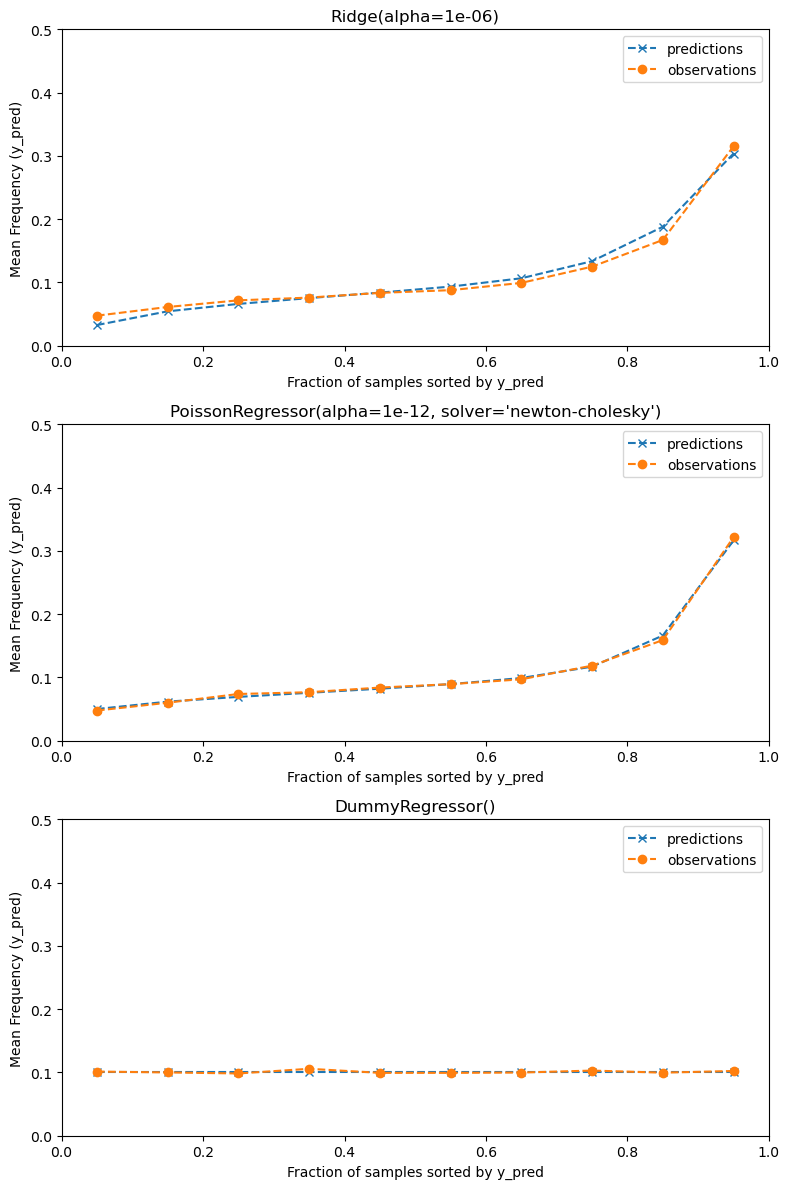

In [35]:
from sklearn.utils import gen_even_slices


def _mean_frequency_by_risk_group(y_true, y_pred, sample_weight=None, n_bins=100):
    """Compare predictions and observations for bins ordered by y_pred.

    We order the samples by ``y_pred`` and split it in bins.
    In each bin the observed mean is compared with the predicted mean.

    Parameters
    ----------
    y_true: array-like of shape (n_samples,)
        Ground truth (correct) target values.
    y_pred: array-like of shape (n_samples,)
        Estimated target values.
    sample_weight : array-like of shape (n_samples,)
        Sample weights.
    n_bins: int
        Number of bins to use.

    Returns
    -------
    bin_centers: ndarray of shape (n_bins,)
        bin centers
    y_true_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    y_pred_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    """
    idx_sort = np.argsort(y_pred)
    bin_centers = np.arange(0, 1, 1 / n_bins) + 0.5 / n_bins
    y_pred_bin = np.zeros(n_bins)
    y_true_bin = np.zeros(n_bins)

    for n, sl in enumerate(gen_even_slices(len(y_true), n_bins)):
        weights = sample_weight[idx_sort][sl]
        y_pred_bin[n] = np.average(y_pred[idx_sort][sl], weights=weights)
        y_true_bin[n] = np.average(y_true[idx_sort][sl], weights=weights)
    return bin_centers, y_true_bin, y_pred_bin


print(f"Actual number of claims: {df_test['ClaimNb'].sum()}")
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8, 12))
plt.subplots_adjust(wspace=0.3)

for axi, model in zip(ax.ravel(), [ridge_glm, poisson_glm, dummy]):
    y_pred = model.predict(df_test)
    y_true = df_test["Frequency"].values
    exposure = df_test["Exposure"].values
    q, y_true_seg, y_pred_seg = _mean_frequency_by_risk_group(
        y_true, y_pred, sample_weight=exposure, n_bins=10
    )

    # Name of the model after the estimator used in the last step of the
    # pipeline.
    print(f"Predicted number of claims by {model[-1]}: {np.sum(y_pred * exposure):.1f}")

    axi.plot(q, y_pred_seg, marker="x", linestyle="--", label="predictions")
    axi.plot(q, y_true_seg, marker="o", linestyle="--", label="observations")
    axi.set_xlim(0, 1.0)
    axi.set_ylim(0, 0.5)
    axi.set(
        title=model[-1],
        xlabel="Fraction of samples sorted by y_pred",
        ylabel="Mean Frequency (y_pred)",
    )
    axi.legend()
plt.tight_layout()

The dummy regression model predicts a constant frequency. This model does not
attribute the same tied rank to all samples but is none-the-less globally
well calibrated (to estimate the mean frequency of the entire population).

The ``Ridge`` regression model can predict very low expected frequencies that
do not match the data. It can therefore severely under-estimate the risk for
some policyholders.

``PoissonRegressor`` shows better
consistency between predicted and observed targets, especially for low
predicted target values.

The sum of all predictions also confirms the calibration issue of the
``Ridge`` model: it under-estimates by more than 3% the total number of
claims in the test set while the other three models can approximately recover
the total number of claims of the test portfolio.

 

## Main takeaways

- The performance of the models can be evaluated by their ability to yield
  well-calibrated predictions and a good ranking.

- The calibration of the model can be assessed by plotting the mean observed
  value vs the mean predicted value on groups of test samples binned by
  predicted risk.

- The least squares loss (along with the implicit use of the identity link
  function) of the Ridge regression model seems to cause this model to be
  badly calibrated. In particular, it tends to underestimate the risk and can
  even predict invalid negative frequencies.

- Using the Poisson loss with a log-link can correct these problems and lead
  to a well-calibrated linear model.
 
- Traditional regression metrics such as Mean Squared Error and Mean Absolute
  Error are hard to meaningfully interpret on count values with many zeros.

